## **1. Cek resource**

In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
# install pre trained model
!pip install transformers

In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=1e7befb3bbb8aa190ada6b70e54d4d69d4d1fa0570eedd1269cbc3e0bd54f614
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## **2. Download & load dataset**

In [ ]:
import wget
import os

print("Downloading dataset...")

url = 'https://github.com/ridife/dataset-idsa/archive/master.zip'

if not os.path.exists('./dataset-idsa.zip'):
  wget.download(url, './dataset-idsa.zip')

In [ ]:
if not os.path.exists('./dataset-idsa-master'):
  !unzip dataset-idsa.zip

Archive:  dataset-idsa.zip
ad6726eb22176338ff77819cb73d7088823e3183
   creating: dataset-idsa-master/
 extracting: dataset-idsa-master/Indonesian Sentiment Tweet Dataset Unlabeled.zip  
  inflating: dataset-idsa-master/Indonesian Sentiment Twitter Dataset Labeled.csv  


In [ ]:
import pandas as pd

df = pd.read_csv("./dataset-idsa-master/Indonesian Sentiment Twitter Dataset Labeled.csv", delimiter='\t')
df.shape

(10806, 2)

In [ ]:
df.sample(5)

,sentimen,Tweet
8994,1,kalau gagal cuba lagi biar selekeh janji otak ...
7969,-1,teringin nak mementaskan drama asiahamiah nuki...
9162,0,posthink aja mungkin mereka lagi miskin
1085,1,kamu mau kemana sih udah disini aja diluar din...
9878,1,satu yang min puji dalam twitter walaupun min ...


In [ ]:
# ubah -1 menjadi 2, karena pada BERT biasanya untuk sent class akan error jika terdapat nilai minus
df['sentimen'] = df['sentimen'].replace(-1, 2)

<Axes: xlabel='sentimen', ylabel='count'>

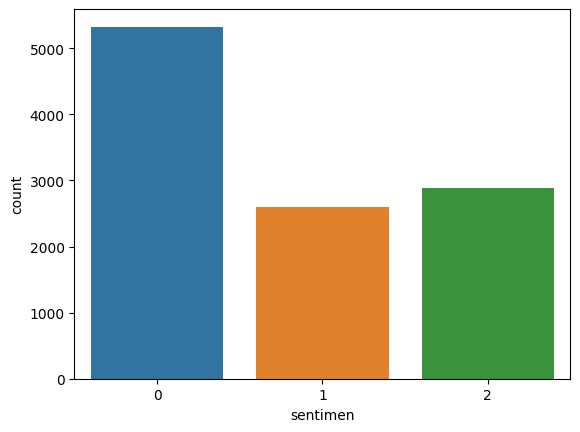

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# x=df.sentimen.value_counts()
# sns.barplot(x.index,x)
# plt.gca().set_ylabel('samples')

sns.countplot(x=df['sentimen'], data=df)

In [ ]:
sentences = df.Tweet.values
labels = df.sentimen.values

## **3. Load BERT Tokenizer**

In [ ]:
from transformers import BertTokenizer

print("Loading BERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

Loading BERT Tokenizer


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
# bert akan memisahkan kata yang tidak ia kenal menjadi yang ia kenal

print("Original: ", sentences[0])

print("Tokenized: ", tokenizer.tokenize(sentences[0]))

print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  lagu bosan apa yang aku save ni huhuhuhuhuhuhuhuhuhuuuuuuuuuuuuuu
Tokenized:  ['lagu', 'bos', '##an', 'apa', 'yang', 'aku', 'save', 'ni', 'hu', '##hu', '##hu', '##hu', '##hu', '##hu', '##hu', '##hu', '##hu', '##hu', '##uu', '##uu', '##uu', '##uu', '##uu', '##uu', '##u']
Token IDS:  [17095, 36737, 10208, 20986, 10290, 39192, 21343, 10219, 18368, 13662, 13662, 13662, 13662, 13662, 13662, 13662, 13662, 13662, 24015, 24015, 24015, 24015, 24015, 24015, 10136]


In [ ]:
input_ids = []

for sent in sentences:
  encoded_sent = tokenizer.encode(
      sent,
      add_special_tokens = True
  )
  input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])



Original:  lagu bosan apa yang aku save ni huhuhuhuhuhuhuhuhuhuuuuuuuuuuuuuu
Token IDs:  [101, 17095, 36737, 10208, 20986, 10290, 39192, 21343, 10219, 18368, 13662, 13662, 13662, 13662, 13662, 13662, 13662, 13662, 13662, 24015, 24015, 24015, 24015, 24015, 24015, 10136, 102]


In [ ]:
print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  51


In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 64 values
Padding token: "[PAD]", ID: 0
Done


In [ ]:
input_ids[0]

array([  101, 17095, 36737, 10208, 20986, 10290, 39192, 21343, 10219,
       18368, 13662, 13662, 13662, 13662, 13662, 13662, 13662, 13662,
       13662, 24015, 24015, 24015, 24015, 24015, 24015, 10136,   102,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [ ]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_mask.append(att_mask)

## **4. Persiapkan data**

In [ ]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_labels, test_labels = train_test_split(input_ids,
                                                                      labels,
                                                                      random_state=2017,
                                                                      test_size=0.1)
train_mask, test_mask, _, _ = train_test_split(attention_mask,
                                               labels,
                                               random_state=2017,
                                               test_size=0.1)

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input,
                                                                                  train_labels,
                                                                                  random_state=2018,
                                                                                  test_size=0.15)
train_mask, validation_mask, _, _ = train_test_split(train_mask,
                                                     train_mask,
                                                     random_state=2018,
                                                     test_size=0.15)

In [ ]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (8266, 64)
Label:  (8266,)
Mask:  (8266, 64)

== Validation ==
Input:  (1459, 64)
Label:  (1459,)
Mask:  (1459, 64)

== Test ==
Input:  (1081, 64)
Label:  (1081,)
Mask:  (1081, 64)


In [ ]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## **5. Persiapkan model pre-trained BERT**

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
)

model.cuda()

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.
==== Embedding Layer ====
bert.embeddings.word_embeddings.weight                       (105879, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)
==== First Transformers ====
bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
bert.

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 0,
                                             num_training_steps = total_steps)

In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

## **6. Training BERT**

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0

  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):

    # Progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

    loss = outputs[0]

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ===================================
  #             Validation
  # ===================================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1

  print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 10 =======
Training...
Batch    40 of   259.     Elapsed: 0:00:15
Batch    80 of   259.     Elapsed: 0:00:28
Batch   120 of   259.     Elapsed: 0:00:41
Batch   160 of   259.     Elapsed: 0:00:54
Batch   200 of   259.     Elapsed: 0:01:07
Batch   240 of   259.     Elapsed: 0:01:20
   Average training loss: 0.95
   Training epoch took: 0:01:26
Running Validation...
   Accuracy: 0.61
   Validation took: 0:00:05
======= Epoch 2 / 10 =======
Training...
Batch    40 of   259.     Elapsed: 0:00:13
Batch    80 of   259.     Elapsed: 0:00:27
Batch   120 of   259.     Elapsed: 0:00:40
Batch   160 of   259.     Elapsed: 0:00:54
Batch   200 of   259.     Elapsed: 0:01:08
Batch   240 of   259.     Elapsed: 0:01:22
   Average training loss: 0.77
   Training epoch took: 0:01:28
Running Validation...
   Accuracy: 0.64
   Validation took: 0:00:05
======= Epoch 3 / 10 =======
Training...
Batch    40 of   259.     Elapsed: 0:00:14
Batch    80 of   259.     Elapsed: 0:00:28
Batch   120 o

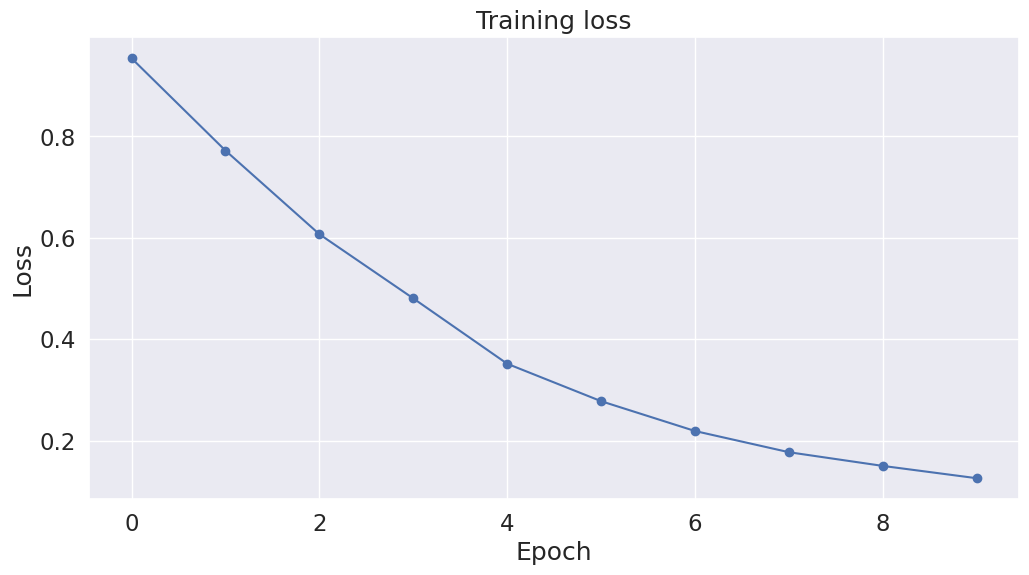

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## **7. Predict dan Evaluate**

In [ ]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 1,081 test sentences
 DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef

flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.408


In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.3f" %acc)


ACC: 0.631
